# EMアルゴリズム
## まずはk-meansを理解する
参考サイト [EMアルゴリズム徹底解説](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)

In [1]:
import os
import numpy as np
import numpy.random as rd
import scipy as sp
from scipy import stats as st
from collections import Counter

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

# %config InlineBackend.figure_format='retina'
# OS判別 ======================
flag_win32 = False
try:
    os.uname()
except AttributeError:
    flag_win32 = True

# Mac用フォント設定（yasubeiの環境では上手く行かなかったのでコメントアウトしておきます）
# if not flag_win32:
# #     font_path = '/Library/Fonts/Osaka.ttf'
#     font_path = '/System/Library/Assets/com_apple_MobileAsset_Font5/458cb75c37483d7bcdfd68445b7246c76ecb29a6.asset/AssetData/Osaka.ttf'
#     font_prop = font_manager.FontProperties(fname=font_path)
#     matplotlib.rcParams['font.family'] = font_prop.get_name()
#     plt.rcParams['font.family'] = 'Osaka'
#     print("{}".format(matplotlib.rcParams['font.family']))


In [2]:
# 定数定義
K_MEANS_GIF = "image/k-means_anim.gif"

In [3]:
color_dict = {0: 'r', 1: 'g', 2: 'b'}

check:  0 [0.2 0.5] [[0.1   0.085]
 [0.085 0.1  ]] 0.0027750000000000014
check:  1 [1.2 0.5] [[ 0.1   -0.085]
 [-0.085  0.1  ]] 0.0027750000000000014
check:  2 [2.  0.5] [[0.1   0.085]
 [0.085 0.1  ]] 0.0027750000000000014


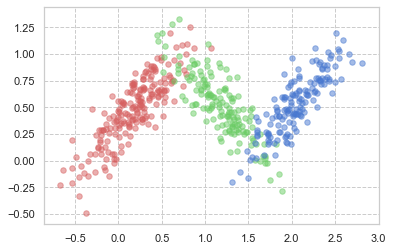

In [4]:
D = 2
K = 3
n = [200, 150, 150]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(71)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]
        
# plot generated data        
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

In [18]:
org_data

array([[0.43436004, 0.52756563, 0.        ],
       [0.29274392, 0.6775126 , 0.        ],
       [0.28661299, 0.6880585 , 0.        ],
       ...,
       [1.90711333, 0.42156959, 2.        ],
       [2.65851892, 0.99623693, 2.        ],
       [2.08509966, 0.64975671, 2.        ]])

In [19]:
org_data[0]

array([0.43436004, 0.52756563, 0.        ])

# Initialize

init mu:
 [[-0.22402299  0.79766021]
 [ 2.59420802  1.08534325]
 [ 0.7036751   0.18799401]]


Text(0.5, 1.0, 'initial state')

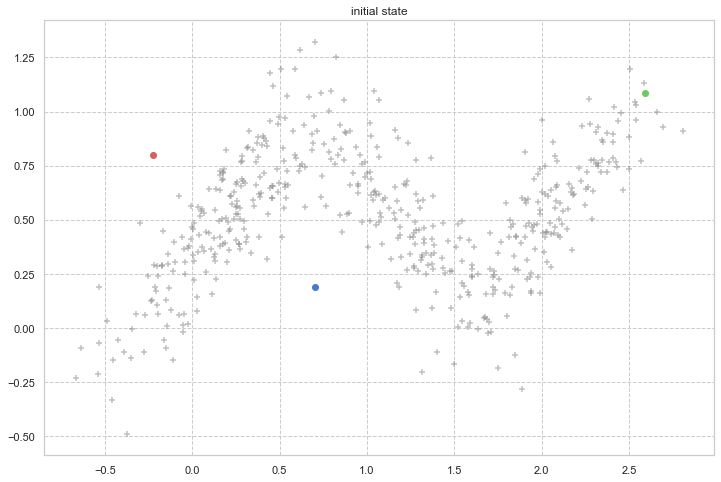

In [14]:
# initialize mu
max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
mu = np.c_[rd.uniform(low=min_x, high=max_x, size=K), rd.uniform(low=min_y, high=max_y, size=K) ]
print('init mu:\n', mu)

# visalize for check
plt.figure(figsize=(12,8))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")

for i in range(3):
    plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
plt.title('initial state')

# k-means algorithm

In [15]:
# for _iter in range(100):
def animate(nframe):
    global mu
    print('nframe:', nframe)
    plt.clf()
    
    if nframe <= 3:
        print('initial state')
        plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")
        for i in range(3):
            plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
        plt.title('initial state')
        return

    # Step 1
    # calculate nearest mu[k]
    r = np.zeros(N)
    for i in range(N):
        r[i] = np.argmin([np.linalg.norm(data[i]-mu[k]) for k in range(K)])

    # Step 2
    cnt = dict(Counter(r))
    N_k = [cnt[k] for k in range(K)]
    mu_prev = mu.copy()
    mu = np.asanyarray([np.sum(data[r == k],axis=0)/N_k[k] for k in range(K)])
    diff = mu - mu_prev
    print('diff:\n', diff)

    # visualize
    #plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=color_dict[r[i]], alpha=0.5, marker="+")

    ax = plt.axes()
    for i in range(K):
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8,head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
    plt.title("iter:{}".format(nframe))
    
    if np.abs(np.sum(diff)) < 0.0001:
        plt.title('mu is converged.')
    else:
        plt.title("iter:{}".format(nframe))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


nframe: 0
initial state
nframe: 0
initial state
nframe: 1
initial state
nframe: 2
initial state
nframe: 3
initial state
nframe: 4
diff:
 [[ 0.28797237 -0.32538917]
 [-0.4511778  -0.4631023 ]
 [ 0.31951133  0.28690927]]


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


nframe: 5
diff:
 [[ 0.05413427 -0.0257516 ]
 [-0.07188712 -0.08624915]
 [ 0.09882205  0.08148137]]
nframe: 6
diff:
 [[ 0.00688512  0.0059873 ]
 [-0.01813298 -0.01404264]
 [-0.00731991  0.00938051]]
nframe: 7
diff:
 [[ 0.          0.        ]
 [-0.01189739 -0.00862283]
 [-0.0120096   0.00985686]]
nframe: 8
diff:
 [[ 0.          0.        ]
 [-0.00613413 -0.0049947 ]
 [-0.00581433  0.00599834]]
nframe: 9
diff:
 [[-0.00225775 -0.00333736]
 [-0.00305952 -0.00186586]
 [-0.00649184  0.00559734]]
nframe: 10
diff:
 [[ 0.          0.        ]
 [-0.00913025 -0.00648667]
 [-0.00878992  0.00864947]]
nframe: 11
diff:
 [[-0.00208631 -0.00407398]
 [-0.00319078 -0.00404147]
 [-0.00655443  0.009044  ]]
nframe: 12
diff:
 [[-0.00223555 -0.00287618]
 [-0.00575718 -0.00049882]
 [-0.00981993  0.00445184]]
nframe: 13
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 14
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 15
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 16
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 17
diff:
 [[0

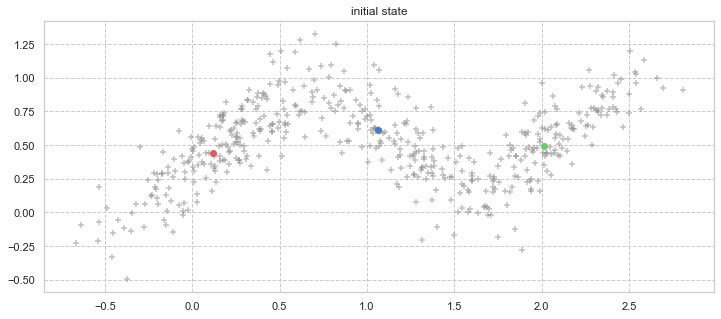

In [16]:
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=40)
anim.save(K_MEANS_GIF, writer='imagemagick', fps=3, dpi=128)

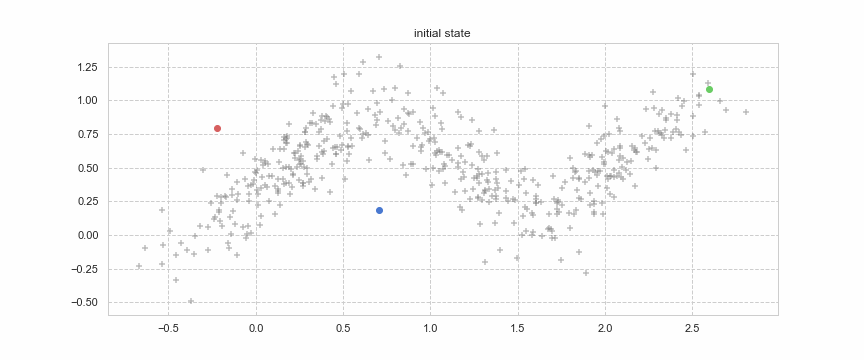

In [17]:
from IPython.display import Image
Image(K_MEANS_GIF)

# 作成したGIFのフレームを1枚だけ表示してみる
[参考](https://www.lifewithpython.com/2017/10/python-extract-gif-frames.html)

In [9]:
from PIL import Image, ImageSequence

def get_gif_frames(path):
    '''パスで指定されたファイルのフレーム一覧を取得する
    '''
    im = Image.open(path)
    return (frame.copy() for frame in ImageSequence.Iterator(im))

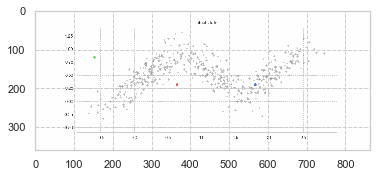

In [10]:
gif_frames = list(get_gif_frames(K_MEANS_GIF))

#画像をarrayに変換
im_list = np.asarray(gif_frames[0].convert("RGBA"))

#貼り付け
plt.imshow(im_list)

#表示
plt.show()